In [1]:
import datetime
import time
from datetime import timezone
from datetime import datetime
import json
import numpy as np
import pandas as pd 
import json
from tensorflow.keras import layers
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [6]:
eye_data

,x,y,status
0,x,y,status
1,1016,459,1
2,1001,464,1
3,998,476,1
4,1001,482,1
...,...,...,...
1477937,466,524,0
1477938,461,494,0
1477939,448,489,0
1477940,469,479,0


In [2]:
np.set_printoptions(precision=15, suppress=True)
eye_data = pd.read_csv(
    "/content/finalfinal.csv",
    names=["participant", "set", "activity", "x", "y", "timestamp", "status"])

one_hot = OneHotEncoder()
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
ct1 = make_column_transformer(
    (categorical_preprocessor, ["activity"])
)
ct2 = make_column_transformer(
    (MinMaxScaler(), [["x", "y", "timestamp"]])
)
eye_data = eye_data.dropna()
eye_data = eye_data.drop(["set", "participant", "activity", "timestamp"], axis="columns")

X_eye = eye_data[["x", "y"]]
y_eye = eye_data[["status"]]

X_eye

,x,y
0,1001,464
1,998,476
2,1001,482
3,1011,489
4,999,466
...,...,...
1477577,107,463
1477578,160,398
1477579,94,475
1477580,128,479


In [3]:
ct = make_column_transformer(
    (MinMaxScaler(), ["x", "y"])
)

ct.fit(X_eye, y_eye)
X_eye = ct.transform(X_eye)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_eye, y_eye, test_size=0.2, random_state=62)

In [12]:
import os
import datetime
# creating tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving to: {log_dir}")
  return tensorboard_callback

# ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, 
                                            save_best_only=True)

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

# simple dense model architecture
btc_model_16 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="linear")
], name="model_16")

btc_model_16.compile(loss = "mae",
                    optimizer = tf.optimizers.Adam(learning_rate=0.0001),
                    metrics=["mae"])

history = btc_model_16.fit(x=X_train, y=y_train, 
                          batch_size=1024, 
                          validation_data=(X_test, y_test),
                          epochs=50, 
                          callbacks=[early_stopping, create_model_checkpoint(model_name=btc_model_16.name), create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name=btc_model_16.name)])

# evaluate and predict
btc_model_16.evaluate(X_test, y_test, batch_size=64)
y_pred_1 = btc_model_16.predict(X_test)

btc_model_16.save("btc_model_16")
btc_model_16.save("btc_model_16.h5")

Saving to: tensorflow_hub/model_16/20220528-203523
Epoch 1/50
1155/1155 [==============================] - 8s 6ms/step - loss: 0.2354 - mae: 0.2354 - val_loss: 0.1846 - val_mae: 0.1846
Epoch 2/50
1155/1155 [==============================] - 5s 4ms/step - loss: 0.1608 - mae: 0.1608 - val_loss: 0.1455 - val_mae: 0.1455
Epoch 3/50
1155/1155 [==============================] - 5s 4ms/step - loss: 0.1402 - mae: 0.1402 - val_loss: 0.1351 - val_mae: 0.1351
Epoch 4/50
1155/1155 [==============================] - 5s 4ms/step - loss: 0.1346 - mae: 0.1346 - val_loss: 0.1314 - val_mae: 0.1314
Epoch 5/50
1155/1155 [==============================] - 5s 4ms/step - loss: 0.1332 - mae: 0.1332 - val_loss: 0.1304 - val_mae: 0.1304
Epoch 6/50
1155/1155 [==============================] - 5s 5ms/step - loss: 0.1329 - mae: 0.1329 - val_loss: 0.1297 - val_mae: 0.1297
Epoch 7/50
1155/1155 [==============================] - 5s 5ms/step - loss: 0.1318 - mae: 0.1318 - val_loss: 0.1297 - val_mae: 0.1297
Epoch 8/50


Text(0.5, 0, 'epochs')

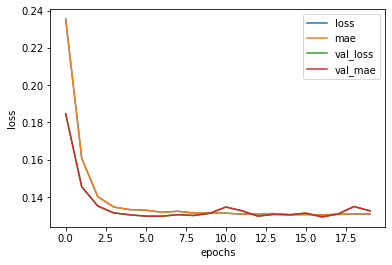

In [13]:
# plot loss curve
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")